# Google Drive Connection

In [1]:
## Connecting google drive to colab

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# Imports

In [99]:
from __future__ import print_function
import math
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
import matplotlib.pyplot as plt

!pip install torchsummary
from torchsummary import summary

# Model

In [0]:
#dropout_value = 0.05
class Net(nn.Module):
    def __init__(self, dropout_value):
        super(Net, self).__init__()

        self.dropout_value = dropout_value

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(self.dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(self.dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # input_size = 8x8x16, output_size = 6x6x16, RF = 18x18
                
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        # ) # input_size = 1x1x16, output_size = 1x1x16, RF = 38x38
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x10, RF = 38x38 


        #self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        #x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Training Code


In [0]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc, l1=False, lambda1=0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # if L1 reg
    if l1:
      loss += L1_regularization(model, lambda1)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


# Testing Code


In [0]:
def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


# Regularization Techniques (dropout, L1, L2, etc)


In [0]:
def L1_regularization(model, factor):
  reg_loss = 0
  for param in model.parameters():
    if param.dim() > 1:
      reg_loss += param.norm(1)
  loss = factor * reg_loss

  return loss


# Dataloader/Transformations/Image-augmentations


In [0]:
def generate_train_test_loader(SEED):
  # Train Phase transformations
  train_transforms = transforms.Compose([
                                        transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                        #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                        # Note the difference between (0.1307) and (0.1307,)
                                        ])

  # Test Phase transformations
  test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])

  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  # CUDA?
  cuda = torch.cuda.is_available()

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  return train_loader, test_loader, test


# Misc Items like finding misclassified images

In [0]:
# visualize accuracy and loss graph
def visualize_graph(train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc[4000:])
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

def set_device():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  return device

# view and save comparison graph of cal accuracy and loss
def visualize_save_comparison_graph(EPOCHS, dict_list, title, xlabel, ylabel, PATH, name="fig"):
  plt.figure(figsize=(20,10))
  epochs = range(1,EPOCHS+1)
  for label, item in dict_list.items():
    plt.plot(epochs, item, label=label)
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(PATH+"/visualization/"+name+".png")

# view and save misclassified images
def show_save_misclassified_images(model, test_loader, name="fig", max_misclassified_imgs=25):
  cols = 5
  rows = math.ceil(max_misclassified_imgs / cols)
  
  with torch.no_grad():
    ind = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      misclassified_imgs_pred = pred[pred.eq(target.view_as(pred))==False]
      
      misclassified_imgs_data = data[pred.eq(target.view_as(pred))==False]
      misclassified_imgs_target = target[(pred.eq(target.view_as(pred))==False).view_as(target)]
      if ind == 0:
        example_data, example_targets, example_preds = misclassified_imgs_data, misclassified_imgs_target, misclassified_imgs_pred
      elif example_data.shape[0] < max_misclassified_imgs:
        example_data = torch.cat([example_data, misclassified_imgs_data], dim=0)
        example_targets = torch.cat([example_targets, misclassified_imgs_target], dim=0)
        example_preds = torch.cat([example_preds, misclassified_imgs_pred], dim=0)
      else:
        break
      ind += 1
    example_data, example_targets, example_preds = example_data[:max_misclassified_imgs], example_targets[:max_misclassified_imgs], example_preds[:max_misclassified_imgs]

  fig = plt.figure(figsize=(20,10))
  for i in range(max_misclassified_imgs):
    plt.subplot(rows,cols,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i].cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f"{i+1}) Ground Truth: {example_targets[i]},\n Prediction: {example_preds[i]}")
    plt.xticks([])
    plt.yticks([])
  plt.savefig(PATH+"/visualization/"+name+".png")


# Execution(Run models for 40 epochs)

In [0]:
# google drive path for saving models, graphs and images
PATH = "drive/EVA4/Session6"

## Generating Data Loaders

In [11]:
SEED = 1
train_loader, test_loader, test_data = generate_train_test_loader(SEED)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## 1) Without L1/L2

**************************************************
******************** Without L1/L2 Regularization ********************
**************************************************

 Initializing...
Creating model...


  0%|          | 0/469 [00:00<?, ?it/s]


 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14  

Loss=0.07416483759880066 Batch_id=468 Accuracy=90.68: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.09154649823904037 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9767/10000 (97.67%)

EPOCH: 3


Loss=0.0550544448196888 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.11076843738555908 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.10161816328763962 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:17<00:00, 27.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Loss=0.19932174682617188 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.0701892077922821 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.049305837601423264 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.08652419596910477 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.0713202953338623 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.19303889572620392 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.03403710201382637 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.040311723947525024 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.04294601082801819 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.12531931698322296 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.006563827395439148 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.09344858676195145 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.07492624968290329 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.008935242891311646 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.006503159645944834 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.012805342674255371 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.2011789083480835 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.011059711687266827 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.10956142097711563 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.03476582467556 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.07159470021724701 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9933/10000 (99.33%)

EPOCH: 27


Loss=0.10807758569717407 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9926/10000 (99.26%)

EPOCH: 28


Loss=0.023085057735443115 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

EPOCH: 29


Loss=0.01129046082496643 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.009296576492488384 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.009050722233951092 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 32


Loss=0.007777546998113394 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


Loss=0.05797730013728142 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:17<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 34


Loss=0.018891682848334312 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 35


Loss=0.005340983625501394 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 36


Loss=0.042071565985679626 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.029645437374711037 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.03319545462727547 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9955/10000 (99.55%)

EPOCH: 39


Loss=0.013348832726478577 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9932/10000 (99.32%)

EPOCH: 40


Loss=0.021846160292625427 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]



Test set: Average loss: 0.0200, Accuracy: 9927/10000 (99.27%)


 Saving trained model...

 Visualizing:


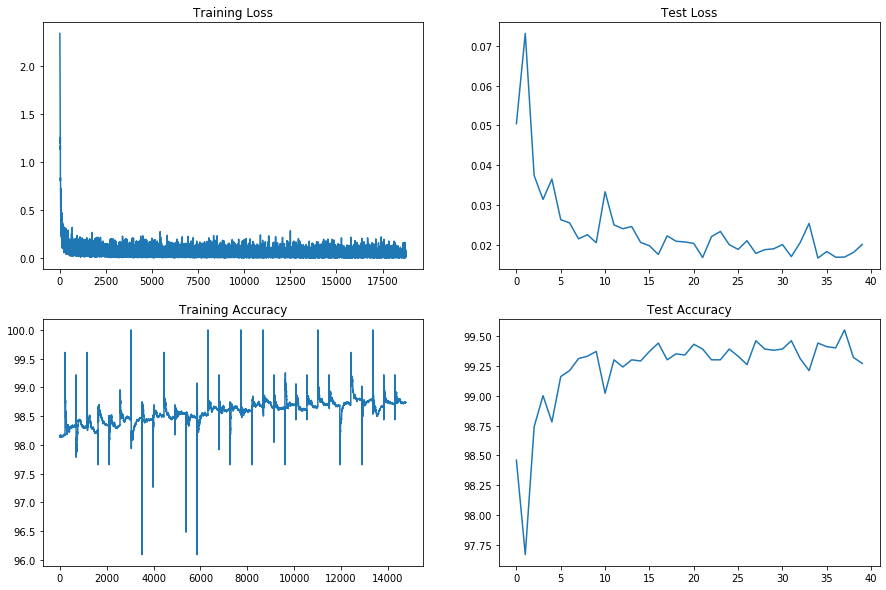

In [12]:
print("*"*50)
print("*"*20,"Without L1/L2 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
no_reg_train_losses = []
no_reg_test_losses = []
no_reg_train_acc = []
no_reg_test_acc = []
dropout_value = 0.05
LAMBDA1=0.0005
LR=0.1
MOMENTUM=0.9
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(model, input_size=inp_size)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, no_reg_train_losses, no_reg_train_acc)
    test(model, device, test_loader, no_reg_test_losses, no_reg_test_acc)

print("\n Saving trained model...")
torch.save(model.state_dict(), PATH+"/models/model_dropout.pth")

print("\n Visualizing:")
visualize_graph(no_reg_train_losses, no_reg_train_acc, no_reg_test_losses, no_reg_test_acc)

## With L1

  0%|          | 0/469 [00:00<?, ?it/s]

**************************************************
******************** With L1 Regularization ********************
**************************************************

 Initializing...
Creating model...

 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           

Loss=0.41660743951797485 Batch_id=468 Accuracy=89.04: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0967, Accuracy: 9692/10000 (96.92%)

EPOCH: 2


Loss=0.3966342806816101 Batch_id=468 Accuracy=95.30: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1531, Accuracy: 9561/10000 (95.61%)

EPOCH: 3


Loss=0.2800373136997223 Batch_id=468 Accuracy=95.56: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9771/10000 (97.71%)

EPOCH: 4


Loss=0.30825909972190857 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9810/10000 (98.10%)

EPOCH: 5


Loss=0.31453898549079895 Batch_id=468 Accuracy=95.80: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9841/10000 (98.41%)

EPOCH: 6


Loss=0.3337818384170532 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:16<00:00, 27.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 9812/10000 (98.12%)

EPOCH: 7


Loss=0.36476990580558777 Batch_id=468 Accuracy=95.76: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9798/10000 (97.98%)

EPOCH: 8


Loss=0.2638130784034729 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9833/10000 (98.33%)

EPOCH: 9


Loss=0.4233207404613495 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0893, Accuracy: 9715/10000 (97.15%)

EPOCH: 10


Loss=0.40137213468551636 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0727, Accuracy: 9764/10000 (97.64%)

EPOCH: 11


Loss=0.26630309224128723 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9860/10000 (98.60%)

EPOCH: 12


Loss=0.3509673476219177 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9798/10000 (97.98%)

EPOCH: 13


Loss=0.36630314588546753 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9832/10000 (98.32%)

EPOCH: 14


Loss=0.3293570876121521 Batch_id=468 Accuracy=96.01: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0743, Accuracy: 9749/10000 (97.49%)

EPOCH: 15


Loss=0.3989333510398865 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0625, Accuracy: 9801/10000 (98.01%)

EPOCH: 16


Loss=0.3809838593006134 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9808/10000 (98.08%)

EPOCH: 17


Loss=0.3306539058685303 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9787/10000 (97.87%)

EPOCH: 18


Loss=0.2593693733215332 Batch_id=468 Accuracy=95.82: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9795/10000 (97.95%)

EPOCH: 19


Loss=0.38363116979599 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0756, Accuracy: 9769/10000 (97.69%)

EPOCH: 20


Loss=0.35531336069107056 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9772/10000 (97.72%)

EPOCH: 21


Loss=0.527384340763092 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9826/10000 (98.26%)

EPOCH: 22


Loss=0.42386817932128906 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:16<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9792/10000 (97.92%)

EPOCH: 23


Loss=0.27259430289268494 Batch_id=468 Accuracy=95.87: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9792/10000 (97.92%)

EPOCH: 24


Loss=0.2586304545402527 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9814/10000 (98.14%)

EPOCH: 25


Loss=0.29825568199157715 Batch_id=468 Accuracy=95.97: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9796/10000 (97.96%)

EPOCH: 26


Loss=0.3145821988582611 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9820/10000 (98.20%)

EPOCH: 27


Loss=0.4425874650478363 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9803/10000 (98.03%)

EPOCH: 28


Loss=0.2824287414550781 Batch_id=468 Accuracy=95.97: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0625, Accuracy: 9800/10000 (98.00%)

EPOCH: 29


Loss=0.3241040110588074 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9815/10000 (98.15%)

EPOCH: 30


Loss=0.2827625870704651 Batch_id=468 Accuracy=96.10: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9809/10000 (98.09%)

EPOCH: 31


Loss=0.29309648275375366 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9811/10000 (98.11%)

EPOCH: 32


Loss=0.2504414916038513 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0622, Accuracy: 9797/10000 (97.97%)

EPOCH: 33


Loss=0.38105955719947815 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:16<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9780/10000 (97.80%)

EPOCH: 34


Loss=0.334286630153656 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9804/10000 (98.04%)

EPOCH: 35


Loss=0.28311091661453247 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9817/10000 (98.17%)

EPOCH: 36


Loss=0.30120158195495605 Batch_id=468 Accuracy=95.87: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9809/10000 (98.09%)

EPOCH: 37


Loss=0.251796156167984 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9807/10000 (98.07%)

EPOCH: 38


Loss=0.4494931399822235 Batch_id=468 Accuracy=96.00: 100%|██████████| 469/469 [00:16<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9812/10000 (98.12%)

EPOCH: 39


Loss=0.36559242010116577 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9789/10000 (97.89%)

EPOCH: 40


Loss=0.39023226499557495 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]



Test set: Average loss: 0.0539, Accuracy: 9830/10000 (98.30%)


 Saving trained model...

 Visualizing:


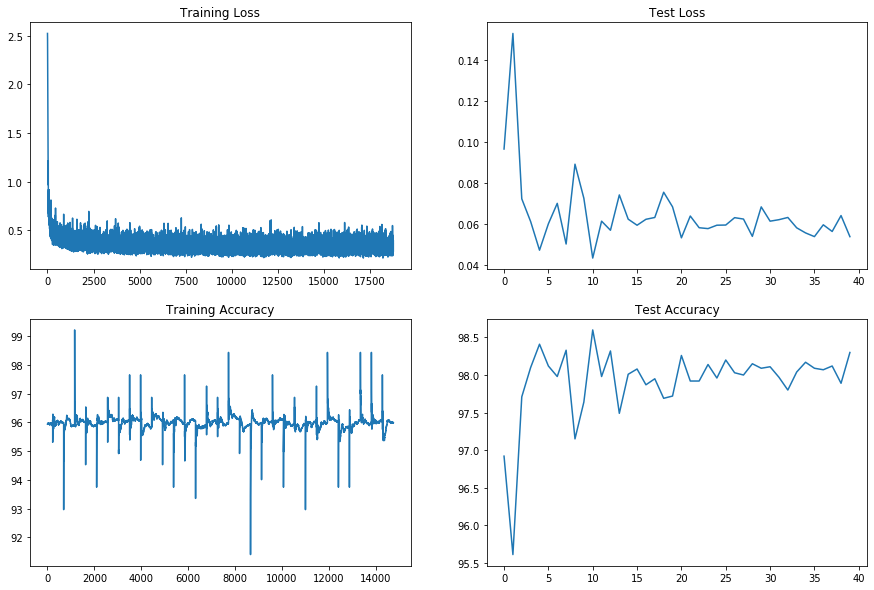

In [14]:
print("*"*50)
print("*"*20,"With L1 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
l1_reg_train_losses = []
l1_reg_test_losses = []
l1_reg_train_acc = []
l1_reg_test_acc = []
dropout_value = 0.05
LAMBDA1=0.0005
LR=0.1
MOMENTUM=0.9
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
l1_model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(l1_model, input_size=inp_size)
optimizer = optim.SGD(l1_model.parameters(), lr=LR, momentum=MOMENTUM)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(l1_model, device, train_loader, optimizer, epoch, l1_reg_train_losses, l1_reg_train_acc, l1=True, lambda1=LAMBDA1)
    test(l1_model, device, test_loader, l1_reg_test_losses, l1_reg_test_acc)

print("\n Saving trained model...")
torch.save(l1_model.state_dict(), PATH+"/models/model_l1.pth")

print("\n Visualizing:")
visualize_graph(l1_reg_train_losses, l1_reg_train_acc, l1_reg_test_losses, l1_reg_test_acc)

## 3) With L2

  0%|          | 0/469 [00:00<?, ?it/s]

**************************************************
******************** With L2 Regularization ********************
**************************************************

 Initializing...
Creating model...

 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           

Loss=0.010398507118225098 Batch_id=468 Accuracy=90.81: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.08477532863616943 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.07146706432104111 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.044026006013154984 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.019626611843705177 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.05247396230697632 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.08326292783021927 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:15<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.02550181932747364 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.018157193437218666 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.036277055740356445 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 36.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.14534668624401093 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:15<00:00, 37.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.08561432361602783 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.11687757819890976 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.00852514524012804 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.046576764434576035 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.0093694431707263 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.01745041273534298 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.070047527551651 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.04443705081939697 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.18262772262096405 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)

EPOCH: 21


Loss=0.06871894001960754 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.06707227230072021 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.1453334540128708 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.05487009882926941 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.12560348212718964 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9933/10000 (99.33%)

EPOCH: 26


Loss=0.036813389509916306 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 27


Loss=0.0220333281904459 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 28


Loss=0.10335583239793777 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 29


Loss=0.05756925046443939 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.019433708861470222 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.017427319660782814 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 32


Loss=0.02653755433857441 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

EPOCH: 33


Loss=0.0429396778345108 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.014184643514454365 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.06387598812580109 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 36


Loss=0.01692676544189453 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.09980543702840805 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 38


Loss=0.02058170922100544 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Loss=0.04376077279448509 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 40


Loss=0.005748992320150137 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]



Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)


 Saving trained model...

 Visualizing:


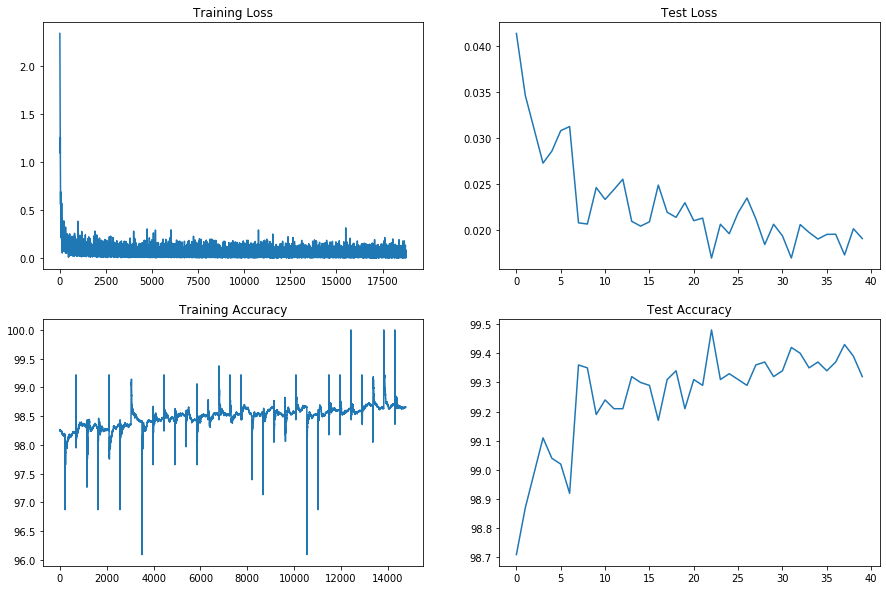

In [15]:
print("*"*50)
print("*"*20,"With L2 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
l2_reg_train_losses = []
l2_reg_test_losses = []
l2_reg_train_acc = []
l2_reg_test_acc = []
dropout_value = 0.05
LR=0.1
MOMENTUM=0.9
WEIGHT_DECAY=1e-5
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
l2_model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(l2_model, input_size=inp_size)
optimizer = optim.SGD(l2_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(l2_model, device, train_loader, optimizer, epoch, l2_reg_train_losses, l2_reg_train_acc)
    test(l2_model, device, test_loader, l2_reg_test_losses, l2_reg_test_acc)

print("\n Saving trained model...")
torch.save(l2_model.state_dict(), PATH+"/models/model_l2.pth")

print("\n Visualizing:")
visualize_graph(l2_reg_train_losses, l2_reg_train_acc, l2_reg_test_losses, l2_reg_test_acc)

## 4) With L1 and L2

  0%|          | 0/469 [00:00<?, ?it/s]

**************************************************
******************** With L1 and L2 Regularization ********************
**************************************************

 Initializing...
Creating model...

 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
    

Loss=0.39213788509368896 Batch_id=468 Accuracy=81.25: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1036, Accuracy: 9729/10000 (97.29%)

EPOCH: 2


Loss=0.26383352279663086 Batch_id=468 Accuracy=95.48: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0761, Accuracy: 9802/10000 (98.02%)

EPOCH: 3


Loss=0.28667786717414856 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:15<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.2171383500099182 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Accuracy: 9785/10000 (97.85%)

EPOCH: 5


Loss=0.22351112961769104 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9796/10000 (97.96%)

EPOCH: 6


Loss=0.35095077753067017 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Loss=0.2840105891227722 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.20513281226158142 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9813/10000 (98.13%)

EPOCH: 9


Loss=0.2099720537662506 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9894/10000 (98.94%)

EPOCH: 10


Loss=0.2289036214351654 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9842/10000 (98.42%)

EPOCH: 11


Loss=0.1968858540058136 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9869/10000 (98.69%)

EPOCH: 12


Loss=0.18696123361587524 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9898/10000 (98.98%)

EPOCH: 13


Loss=0.256229043006897 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9878/10000 (98.78%)

EPOCH: 14


Loss=0.2394426465034485 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9872/10000 (98.72%)

EPOCH: 15


Loss=0.16343532502651215 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:15<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9877/10000 (98.77%)

EPOCH: 16


Loss=0.1948447823524475 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:15<00:00, 38.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9881/10000 (98.81%)

EPOCH: 17


Loss=0.15602119266986847 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9883/10000 (98.83%)

EPOCH: 18


Loss=0.22020897269248962 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9884/10000 (98.84%)

EPOCH: 19


Loss=0.19348806142807007 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9839/10000 (98.39%)

EPOCH: 20


Loss=0.21753361821174622 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9893/10000 (98.93%)

EPOCH: 21


Loss=0.15395715832710266 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9878/10000 (98.78%)

EPOCH: 22


Loss=0.22077736258506775 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9897/10000 (98.97%)

EPOCH: 23


Loss=0.27508705854415894 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9867/10000 (98.67%)

EPOCH: 24


Loss=0.1706690490245819 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9856/10000 (98.56%)

EPOCH: 25


Loss=0.1856880486011505 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9889/10000 (98.89%)

EPOCH: 26


Loss=0.1994248628616333 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9907/10000 (99.07%)

EPOCH: 27


Loss=0.23299960792064667 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:14<00:00, 35.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9879/10000 (98.79%)

EPOCH: 28


Loss=0.21456500887870789 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9856/10000 (98.56%)

EPOCH: 29


Loss=0.20937302708625793 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9884/10000 (98.84%)

EPOCH: 30


Loss=0.2025526463985443 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9881/10000 (98.81%)

EPOCH: 31


Loss=0.1928146630525589 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9875/10000 (98.75%)

EPOCH: 32


Loss=0.18146781623363495 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9884/10000 (98.84%)

EPOCH: 33


Loss=0.19349652528762817 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9855/10000 (98.55%)

EPOCH: 34


Loss=0.15478286147117615 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9870/10000 (98.70%)

EPOCH: 35


Loss=0.16379953920841217 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9856/10000 (98.56%)

EPOCH: 36


Loss=0.169229656457901 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9915/10000 (99.15%)

EPOCH: 37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9854/10000 (98.54%)

EPOCH: 38


Loss=0.2324652075767517 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9886/10000 (98.86%)

EPOCH: 39


Loss=0.24911372363567352 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9902/10000 (99.02%)

EPOCH: 40


Loss=0.25214463472366333 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]



Test set: Average loss: 0.0464, Accuracy: 9854/10000 (98.54%)


 Saving trained model...

 Visualizing:


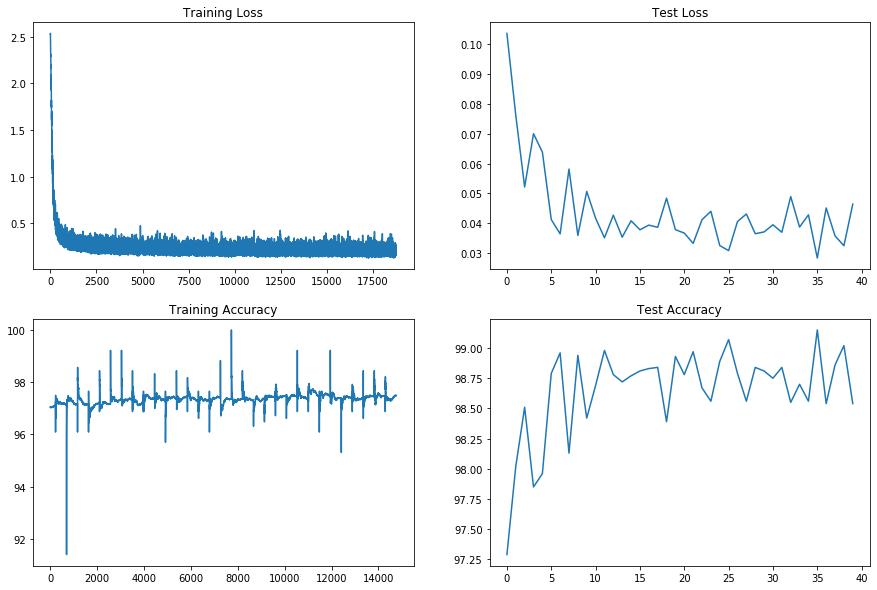

In [18]:
print("*"*50)
print("*"*20,"With L1 and L2 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
l1_l2_reg_train_losses = []
l1_l2_reg_test_losses = []
l1_l2_reg_train_acc = []
l1_l2_reg_test_acc = []
dropout_value = 0.05
LAMBDA1=0.0005
LR=0.01
MOMENTUM=0.9
WEIGHT_DECAY=1e-5
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
l1_l2_model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(l1_l2_model, input_size=inp_size)
optimizer = optim.SGD(l1_l2_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(l1_l2_model, device, train_loader, optimizer, epoch, l1_l2_reg_train_losses, l1_l2_reg_train_acc, l1=True, lambda1=LAMBDA1)
    test(l1_l2_model, device, test_loader, l1_l2_reg_test_losses, l1_l2_reg_test_acc)

print("\n Saving trained model...")
torch.save(l1_l2_model.state_dict(), PATH+"/models/model_l1_l2.pth")

print("\n Visualizing:")
visualize_graph(l1_l2_reg_train_losses, l1_l2_reg_train_acc, l1_l2_reg_test_losses, l1_l2_reg_test_acc)

# Visualising comparison graphs

In [0]:
EPOCHS = 40
acc_dict_list = {'Dropout': no_reg_test_acc, 'Dropout and L1 Reg': l1_reg_test_acc, 'Dropout and L2 Reg': l2_reg_test_acc, 'Dropout, L1 and L2 Reg': l1_l2_reg_test_acc}

loss_dict_list = {'Dropout': no_reg_test_losses, 'Dropout and L1 Reg': l1_reg_test_losses, 'Dropout and L2 Reg': l2_reg_test_losses, 'Dropout, L1 and L2 Reg': l1_l2_reg_test_losses}

In [0]:
import json
with open(PATH+'/acc_loss_data/acc.json', 'w') as fp:
    json.dump(acc_dict_list, fp)

with open(PATH+'/acc_loss_data/loss.json', 'w') as fp:
    json.dump(loss_dict_list, fp)

## 1) Validation Accuracy

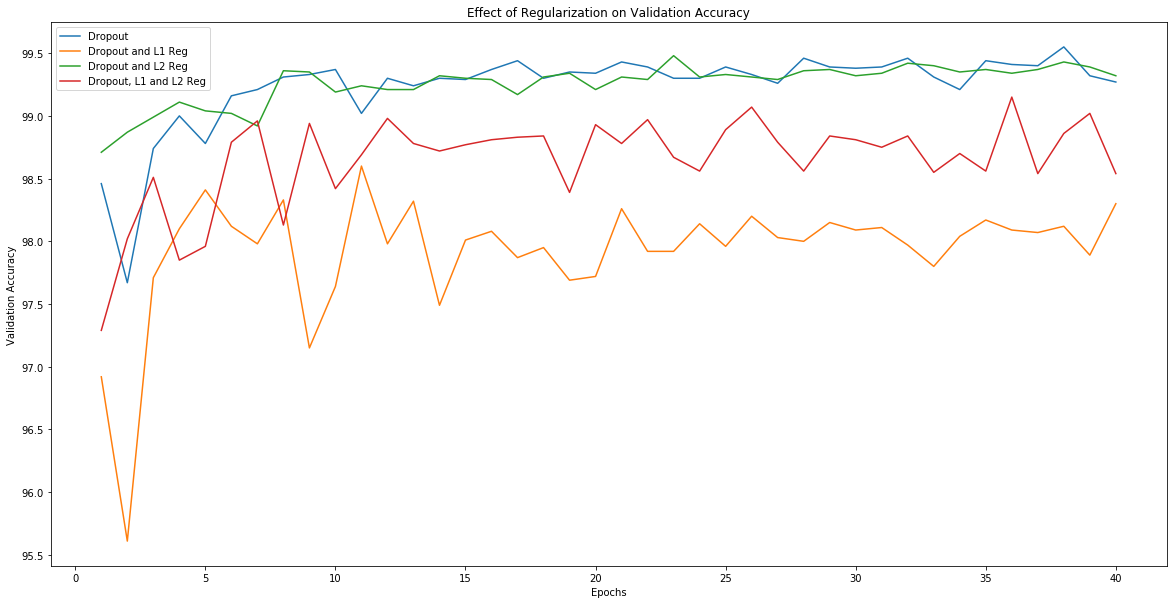

In [113]:
title, xlabel, ylabel = 'Effect of Regularization on Validation Accuracy', 'Epochs', 'Validation Accuracy'
visualize_save_comparison_graph(EPOCHS, acc_dict_list, title, xlabel, ylabel, PATH, name="val_acc_comparison")

## 2) Validation Loss

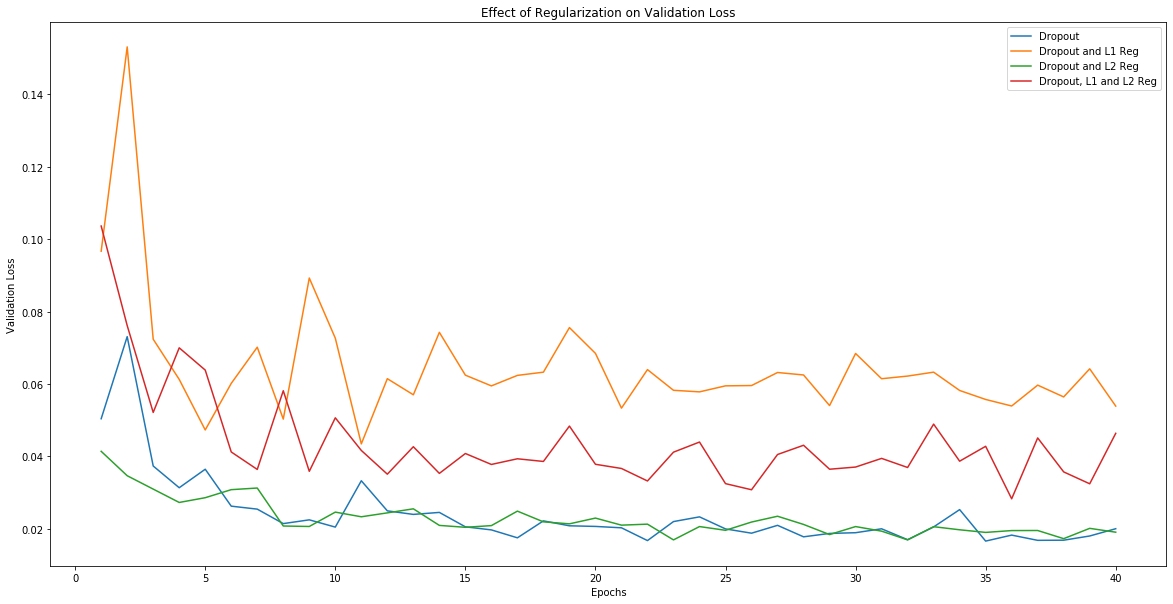

In [110]:
title, xlabel, ylabel = 'Effect of Regularization on Validation Loss', 'Epochs', 'Validation Loss'
visualize_save_comparison_graph(EPOCHS, loss_dict_list, title, xlabel, ylabel, PATH, name="val_loss_comparison")

# Visualize 25 Misclassified Images for L1 and L2 models

## 1) Without L1/L2

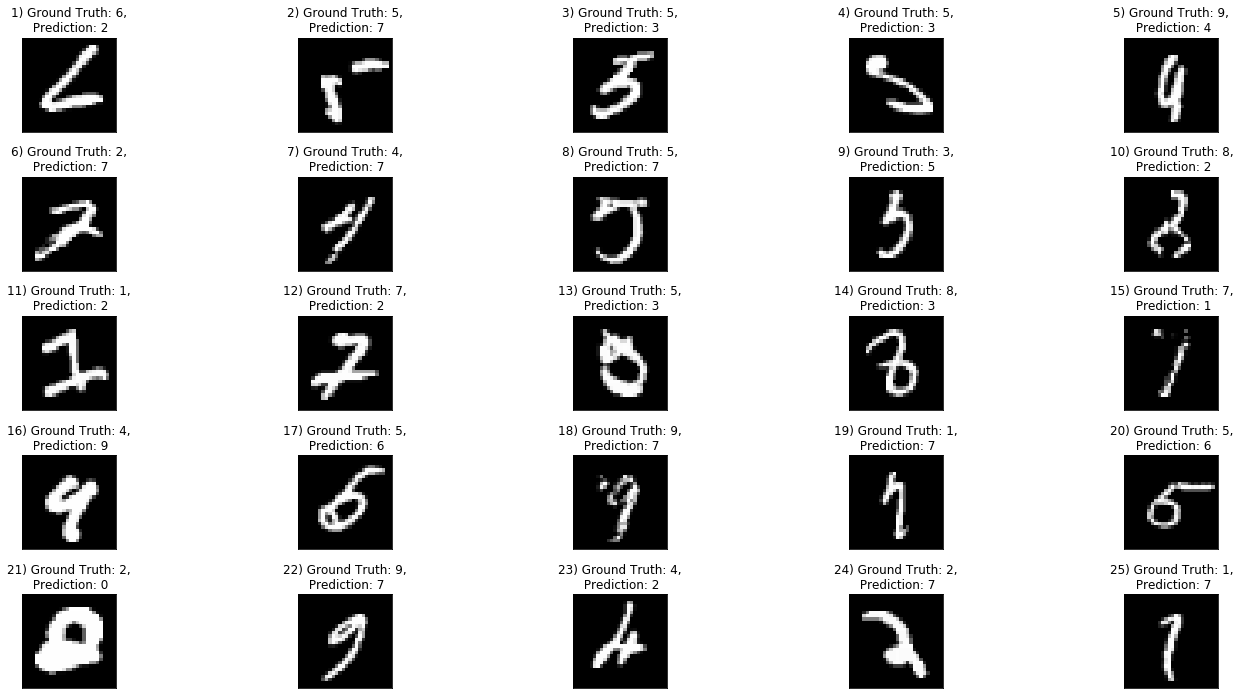

In [109]:
show_save_misclassified_images(model, test_loader, name="no_l1_l2_misclassified_images", max_misclassified_imgs=25)

## 2) For L1

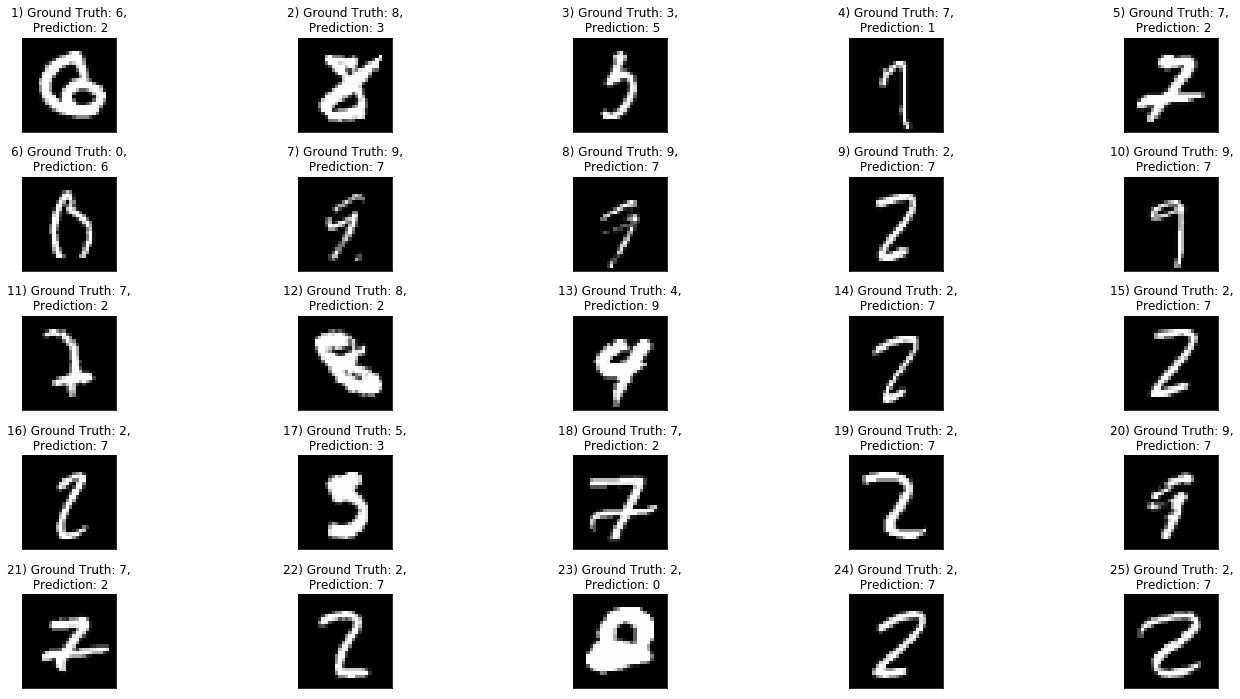

In [107]:
show_save_misclassified_images(l1_model, test_loader, name="l1_misclassified_images", max_misclassified_imgs=25)

## 3) For L2

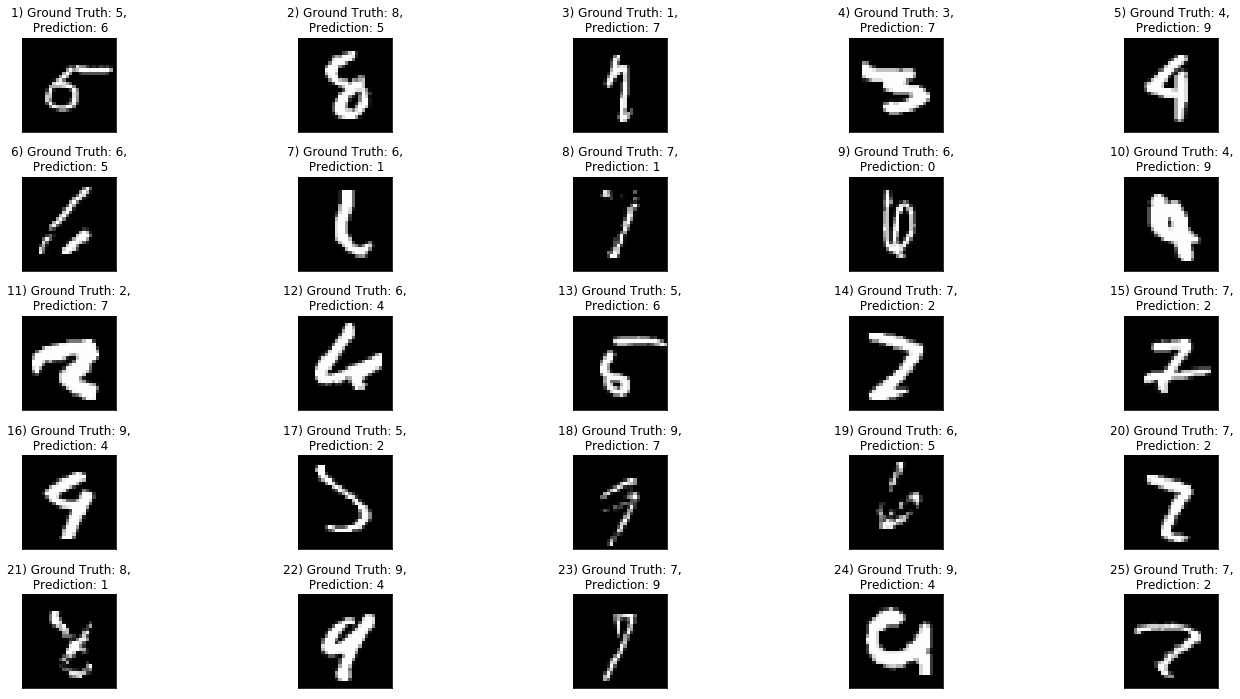

In [106]:
show_save_misclassified_images(l2_model, test_loader, name="l2_misclassified_images", max_misclassified_imgs=25)

## 4) For L1 and L2

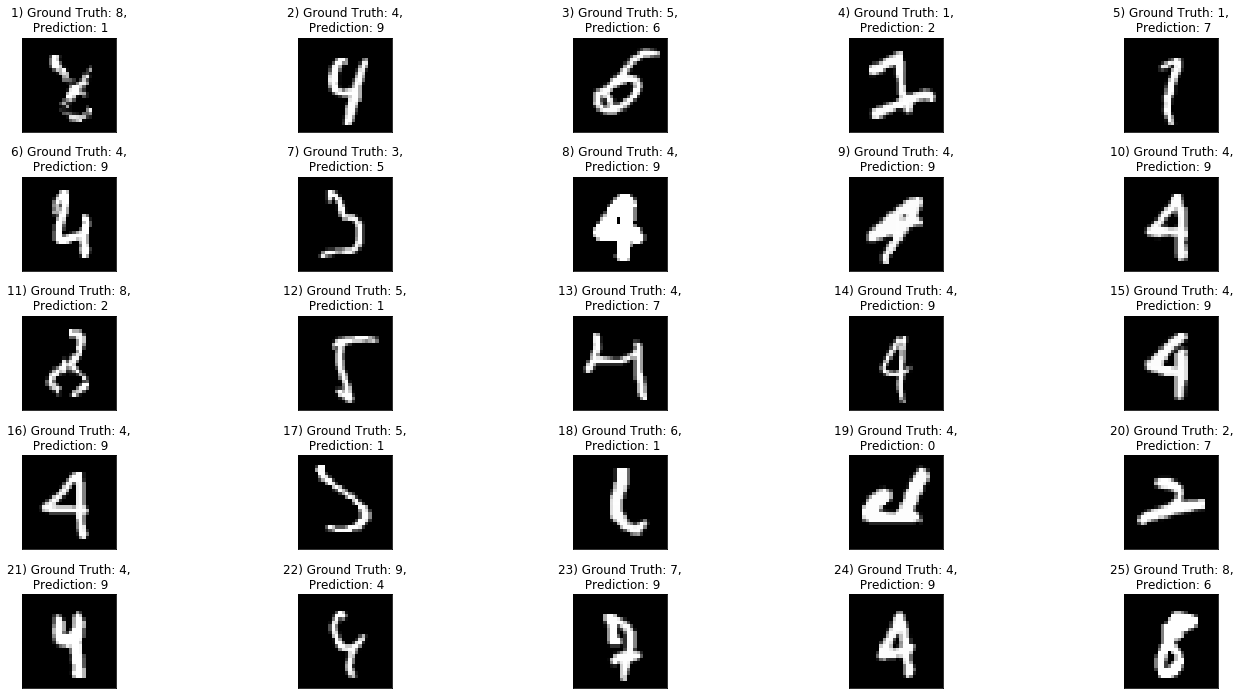

In [108]:
show_save_misclassified_images(l1_l2_model, test_loader, name="l1_l2_misclassified_images", max_misclassified_imgs=25)

# Observations
---

1) From the validation loss comparison graph, we can see that adding L1 regularization to the base model, which already has dropout applied to it, makes the loss more haphazard. This is opposite in effect to adding L2 regularization, which smoothes out the loss curve. Thus, adding both L1 and L2 gives a median of both the curves, as can be seen.

2) From misclassified images, we can see that the network confuses a lot between 7 and 2. Half written digits also confuses the network a lot.